 # Problem statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# Data Sourcing

### Importing Skin Cancer Data

### Importing all the important libraries

In [78]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [83]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [84]:
# Count the number of train and test images loaded
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [85]:
# Lets initialize batch size and image dimensions
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [86]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure you resize your images to the size img_height*img_width, while writting the dataset
train_ds = image_dataset_from_directory(
    directory=data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="training"
    )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [87]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = image_dataset_from_directory(
    directory=data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="validation"
    )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [88]:
# Load the test dataset fully
test_ds = image_dataset_from_directory(
    directory=data_dir_test,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123)

Found 118 files belonging to 9 classes.


In [89]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [90]:
# Lets check the shape of batch dataset
train_ds,val_ds

(<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>,
 <BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>)

# Data Visualization

### Visualize the data
#### visualize one instance of all the nine classes present in the dataset

In [91]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
# lets iterate through first 5 batches of dataset
for images, labels in train_ds.take(5):
  unique_li = []
  unique_images = []
  # make a list of all unique images from each class
  for i in range(32):
    if class_names[labels[i]] not in unique_li:
      unique_li.append(class_names[labels[i]])
      unique_images.append((class_names[labels[i]],images[i]))
  # Check if images from all class are covered, if so then we dont need to check next batch, hence we can break the loop
  if len(unique_images)==9:
    print("Found",len(unique_images),"classes in batch")
    break

Found 9 classes in batch


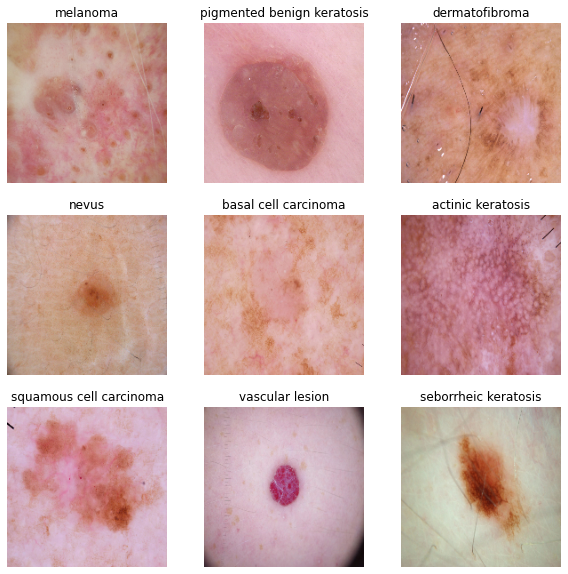

In [92]:
# plot image from unique images list
plt.figure(figsize=(10, 10))
# iterate through all unique images from each class and display using matplotlib
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(unique_images[i][1].numpy().astype("uint8"))
  plt.title(unique_images[i][0])
  plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [93]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Creation and Evaluation

## Vanilla Model

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [94]:
### Your code goes here
img_size = 180
# Build Normalization layer by rescaling between 0-1, lets also specify input shape with 180x180x3 as we will be using this in all future layers
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3))
# Lets build sequential model with 3 conv layers with 16,32,64 filters, 3 max pooling , then flatten the layer , build a dense layer of 128 and conclude with softmax function layer for output 
model = Sequential([
  normalization_layer,# Normalizing 
  layers.experimental.preprocessing.Resizing(img_size, img_size),# Resizing the image to 180x180
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [95]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [96]:
# View the summary of all layers
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
resizing_8 (Resizing)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 45, 45, 64)      

### Train the model

In [97]:
# Lets train the model with batch size of 32
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=32
)

Epoch 1/20
56/56 [==============================] - 16s 67ms/step - loss: 2.1932 - accuracy: 0.2061 - val_loss: 1.8068 - val_accuracy: 0.3311
Epoch 2/20
56/56 [==============================] - 1s 15ms/step - loss: 1.7043 - accuracy: 0.3883 - val_loss: 1.4913 - val_accuracy: 0.4541
Epoch 3/20
56/56 [==============================] - 1s 15ms/step - loss: 1.4216 - accuracy: 0.4991 - val_loss: 1.5472 - val_accuracy: 0.4541
Epoch 4/20
56/56 [==============================] - 1s 15ms/step - loss: 1.3585 - accuracy: 0.5177 - val_loss: 1.3612 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 1s 15ms/step - loss: 1.2228 - accuracy: 0.5551 - val_loss: 1.3975 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 1s 15ms/step - loss: 1.1600 - accuracy: 0.6030 - val_loss: 1.3699 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 1s 15ms/step - loss: 1.1059 - accuracy: 0.6187 - val_loss: 1.4649 - val_accuracy: 0.5168
Epoch 8/20
5

### Visualizing training results

In [98]:
# Lets build a genric function to visualize the accuracy so that it can be used for further evaluation
def plot_accuracy(history,epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

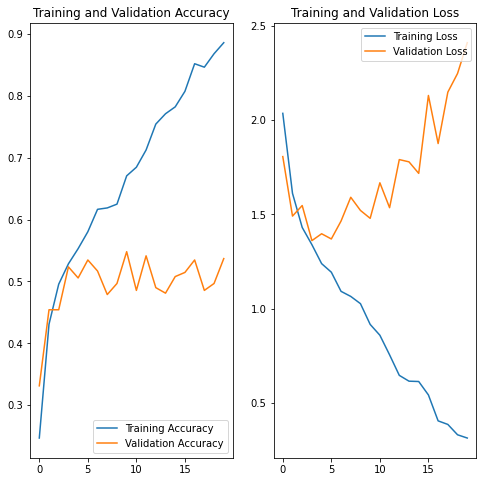

In [99]:
# Lets visualize the vanilla model
plot_accuracy(history,epochs)

In [100]:
# Lets store the final accuracy in a dataframe for the consecutive training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
accuracy_history_df = pd.DataFrame(data=[{"Type":"Vanilla","Training Accuracy":acc[-1],"Validation Accuracy":val_acc[-1],"Epochs":epochs}])
accuracy_history_df

,Type,Training Accuracy,Validation Accuracy,Epochs
0,Vanilla,0.886161,0.536913,20


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Observation
- The training accuracy at the end we got is 89% and validation accuracy is 57%. Since there is huge gap between training and validation accuracy, the model will not perform well on newer dataset. 
- As we can see from the plot that as the number of epochs increases, the training accuracy also increased but the validation accuracy reduced. This is clear case of <b>overfitting</b>. 
- We can also see that training loss decreased and validation loss increased with the number of epochs. 

## Data Augmentaion

In [101]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
# Lets build a layer which performs just the random rotation 
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomRotation(0.2)
])

In [102]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

(-0.5, 179.5, 179.5, -0.5)

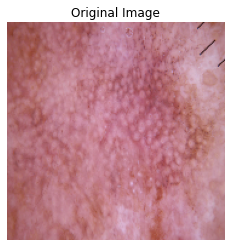

In [103]:
# Pick one of the image from the unique images list
import random
image = tf.expand_dims(unique_images[random.randint(0,9)][1], 0)
plt.imshow(image[0].numpy().astype("uint8"))
plt.title("Original Image")
plt.axis("off")

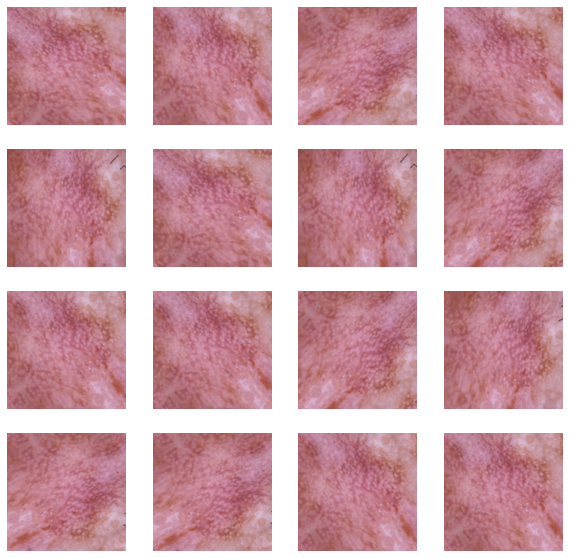

In [104]:
# Pass through the data augmentation layers and display the image to visualize how data is getting augmented 
augmented_image = data_augmentation(image)
plt.figure(figsize=(10, 10))
for i in range(16):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

### Observation
We can see that slight rotations are applied to the images using the data augmentation layer with probablity of 0.2

### Create the model, compile and train the model


In [105]:
## Your code goes here
img_size = 180
# Build the sequential layers same as before with an extra data augmentation layer
model_augm1 = Sequential([
  normalization_layer,# Normalizing 
  layers.experimental.preprocessing.Resizing(img_size, img_size),# resizing the layer
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])


### Compiling the model

In [106]:
## Your code goes here
model_augm1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              )
model_augm1.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
resizing_9 (Resizing)        (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_12 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 45, 45, 32)      

### Training the model

In [107]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
# Lets the fit the model with batch size of 32 and 20 epochs
history_augm1 = model_augm1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=32
)

Epoch 1/20
56/56 [==============================] - 2s 19ms/step - loss: 2.2587 - accuracy: 0.1752 - val_loss: 1.9430 - val_accuracy: 0.2506
Epoch 2/20
56/56 [==============================] - 1s 16ms/step - loss: 1.8088 - accuracy: 0.3617 - val_loss: 1.5844 - val_accuracy: 0.4452
Epoch 3/20
56/56 [==============================] - 1s 16ms/step - loss: 1.4809 - accuracy: 0.4761 - val_loss: 1.4566 - val_accuracy: 0.4720
Epoch 4/20
56/56 [==============================] - 1s 16ms/step - loss: 1.4305 - accuracy: 0.4810 - val_loss: 1.3942 - val_accuracy: 0.5503
Epoch 5/20
56/56 [==============================] - 1s 16ms/step - loss: 1.3594 - accuracy: 0.5153 - val_loss: 1.4164 - val_accuracy: 0.5034
Epoch 6/20
56/56 [==============================] - 1s 19ms/step - loss: 1.4193 - accuracy: 0.4840 - val_loss: 1.3983 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 1s 16ms/step - loss: 1.3118 - accuracy: 0.5375 - val_loss: 1.3719 - val_accuracy: 0.5280
Epoch 8/20
56

### Visualizing the results

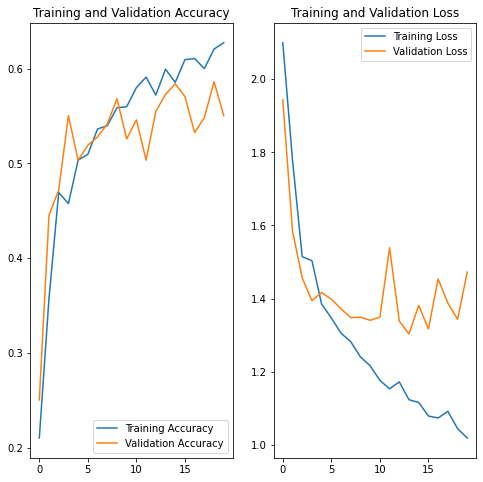

In [108]:
plot_accuracy(history_augm1,epochs)

In [109]:
# Lets store the accuracy in the DF
acc = history_augm1.history['accuracy']
val_acc = history_augm1.history['val_accuracy']
accuracy_history_df = accuracy_history_df.append([{"Type":"Data Augmentation","Training Accuracy":acc[-1],"Validation Accuracy":val_acc[-1],"Epochs":epochs}])
accuracy_history_df

,Type,Training Accuracy,Validation Accuracy,Epochs
0,Vanilla,0.886161,0.536913,20
0,Data Augmentation,0.627232,0.550336,20


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### Observation
- We can see that training accuracy has reduced and test accuracy have improved a little are but they are close to each other now
- but we  see that our model is underfitting as the training accuracy is low

## Create Model with Dropout

### Train by adding dropout
Lets evaluate model by adding dropout layer of 25%

In [110]:
# lets train by adding a dropout of 0.25
model_dropout = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3)),# Normalizing 
  layers.experimental.preprocessing.Resizing(img_size, img_size),
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

### Compile the model

In [111]:
## Your code goes here
model_dropout.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_dropout.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
resizing_10 (Resizing)       (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_12 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 45, 45, 32)      

### Fit the model

In [112]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history_dropout = model_dropout.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=32
)

Epoch 1/20
56/56 [==============================] - 2s 18ms/step - loss: 2.0095 - accuracy: 0.2488 - val_loss: 1.6843 - val_accuracy: 0.3848
Epoch 2/20
56/56 [==============================] - 1s 16ms/step - loss: 1.5670 - accuracy: 0.4554 - val_loss: 1.4663 - val_accuracy: 0.4989
Epoch 3/20
56/56 [==============================] - 1s 16ms/step - loss: 1.4393 - accuracy: 0.5006 - val_loss: 1.4004 - val_accuracy: 0.5302
Epoch 4/20
56/56 [==============================] - 1s 16ms/step - loss: 1.3731 - accuracy: 0.5266 - val_loss: 1.3270 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 1s 16ms/step - loss: 1.3200 - accuracy: 0.5367 - val_loss: 1.3335 - val_accuracy: 0.5481
Epoch 6/20
56/56 [==============================] - 1s 16ms/step - loss: 1.3643 - accuracy: 0.4960 - val_loss: 1.3792 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 1s 16ms/step - loss: 1.2380 - accuracy: 0.5485 - val_loss: 1.3427 - val_accuracy: 0.5324
Epoch 8/20
56

### Visualize the results

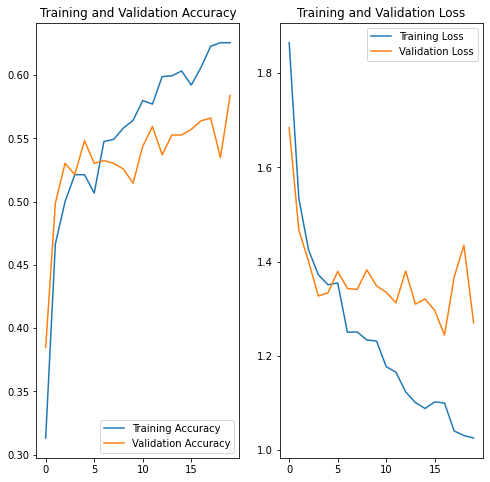

In [113]:
plot_accuracy(history_dropout,epochs)

In [114]:
# Lets store the accuracy in the DF
acc = history_dropout.history['accuracy']
val_acc = history_dropout.history['val_accuracy']
accuracy_history_df = accuracy_history_df.append([{"Type":"Dropout","Training Accuracy":acc[-1],"Validation Accuracy":val_acc[-1],"Epochs":epochs}])
accuracy_history_df

,Type,Training Accuracy,Validation Accuracy,Epochs
0,Vanilla,0.886161,0.536913,20
0,Data Augmentation,0.627232,0.550336,20
0,Dropout,0.625558,0.583893,20


### Observation
- We can see that accuracy of training and validation did not have much affect after adding dropout layer, although making validation accuracy a bit closer to training
- We see that model is still underfitting
- Lets keep the dropout layer, just to add some regularization layer if there is some overfitting in future

## Class Imbalance

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

### Prepare class distribution

In [115]:
## Your code goes here.
# Lets initialize a emtpy dict
class_distr={}
# Go through all training dataset batches
for image_batch, labels_batch in train_ds:
  # prepare the count of images in each class
    for i in range(image_batch.shape[0]):
      if class_names[labels_batch[i]] in class_distr:
        class_distr[class_names[labels_batch[i]]]+=1
      else:
        class_distr[class_names[labels_batch[i]]]=1
# Display the distribution
class_distr

{'actinic keratosis': 92,
 'basal cell carcinoma': 309,
 'dermatofibroma': 77,
 'melanoma': 352,
 'nevus': 277,
 'pigmented benign keratosis': 370,
 'seborrheic keratosis': 58,
 'squamous cell carcinoma': 142,
 'vascular lesion': 115}

In [116]:
# Lets prepare the class distribution Dataframe
df_sample_distr = pd.DataFrame({"Class Name":class_distr.keys(), "Samples":class_distr.values()})
df_sample_distr.sort_values('Samples',ascending=False)

,Class Name,Samples
2,pigmented benign keratosis,370
1,melanoma,352
7,basal cell carcinoma,309
3,nevus,277
0,squamous cell carcinoma,142
8,vascular lesion,115
4,actinic keratosis,92
6,dermatofibroma,77
5,seborrheic keratosis,58


### Visualize Class Distribution

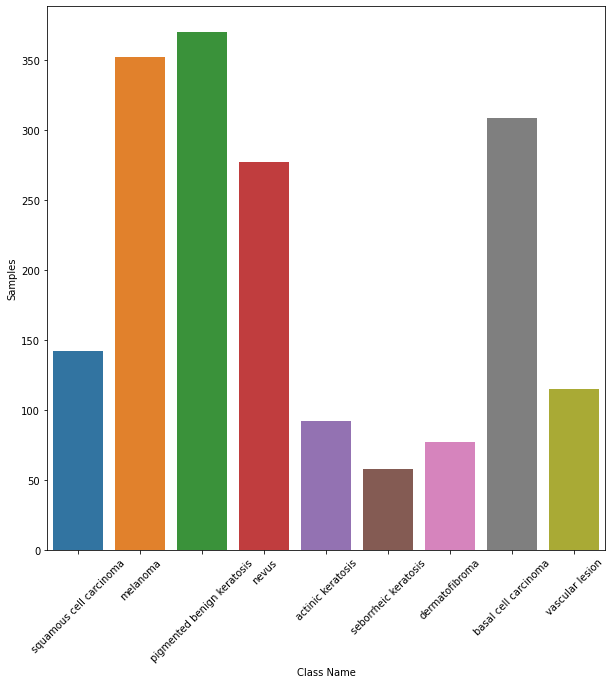

In [117]:
# Lets visualize Class Distribution
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.barplot(data=df_sample_distr,x='Class Name',y='Samples')
plt.xticks(rotation = 45) 
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
>Answer: seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
>Answer: pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [118]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [119]:
# Specify the path to training dataset
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
print("Please hold on for few minutes, as the augmenting takes time")
# Augment 1000 images per class to balance the dataset using Augmentor
for i in class_names:
    print("Augmenting image for class",i)
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) ## We are adding 1000 samples per class to make sure that none of the classes are sparse.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6258A7AF98>:   0%|          | 1/1000 [00:00<02:36,  6.38 Samples/s]

Please hold on for few minutes, as the augmenting takes time
Augmenting image for class actinic keratosis
Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F62C02FAEB8>: 100%|██████████| 1000/1000 [00:31<00:00, 32.24 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Augmenting image for class basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F62C00A4128>: 100%|██████████| 1000/1000 [00:31<00:00, 32.14 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F62550465F8>:   0%|          | 1/1000 [00:00<02:09,  7.70 Samples/s]

Augmenting image for class dermatofibroma
Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F625357DE10>: 100%|██████████| 1000/1000 [00:32<00:00, 31.19 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Augmenting image for class melanoma
Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F62618549E8>: 100%|██████████| 1000/1000 [02:56<00:00,  5.65 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Augmenting image for class nevus
Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7F62D8057048>: 100%|██████████| 1000/1000 [02:34<00:00,  6.46 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6331FDB7B8>:   0%|          | 1/1000 [00:00<02:15,  7.38 Samples/s]

Augmenting image for class pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F625362C908>: 100%|██████████| 1000/1000 [00:31<00:00, 31.91 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Augmenting image for class seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6260CDC748>: 100%|██████████| 1000/1000 [01:15<00:00, 13.32 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Augmenting image for class squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F62C0081358>: 100%|██████████| 1000/1000 [00:30<00:00, 32.94 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Augmenting image for class vascular lesion
Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F62C054E048>: 100%|██████████| 1000/1000 [00:31<00:00, 31.70 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [120]:
# LEts count the number of images added in output folder
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [121]:
# get the list of all paths of images in output folder using regex in glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[0:5]

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000465.jpg_9b2b3636-28f5-4fbf-8a9a-ab193dfa75ec.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028393.jpg_34970895-6c85-4359-9e70-edc72827fed2.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000366.jpg_6d4c4333-15ad-465a-9b19-bac7e241e815.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027536.jpg_adc2ce41-f48c-42ad-95ca-54ea05ef46a4.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000331.jpg_91d0a9ba-8a95-47af-a67d-a34a86f062ea.jpg']

In [122]:
# Get the list of all class names for the above paths
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[0:5]

['nevus', 'nevus', 'nevus', 'nevus', 'nevus']

In [123]:
# Prepare a dictionary by combining the path and class name from above two
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [124]:
# Prepare Dataframe using the dictionary created above
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
print("shape of new dataset",df2.shape)
df2.head()

shape of new dataset (9000, 2)


,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,nevus
1,Skin cancer ISIC The International Skin Imagin...,nevus
2,Skin cancer ISIC The International Skin Imagin...,nevus
3,Skin cancer ISIC The International Skin Imagin...,nevus
4,Skin cancer ISIC The International Skin Imagin...,nevus


In [125]:
# LEts check if it has added 500 images to each class
df2['Label'].value_counts()

dermatofibroma                1000
nevus                         1000
pigmented benign keratosis    1000
basal cell carcinoma          1000
melanoma                      1000
actinic keratosis             1000
seborrheic keratosis          1000
vascular lesion               1000
squamous cell carcinoma       1000
Name: Label, dtype: int64

In [126]:
# Lets prepare a dataframe containing paths to original images present outside of output folder, 
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print("one of the path to original dataset image",path_list[0])
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print("lesion of one of the image",lesion_list[0])
dataframe_dict = dict(zip(path_list, lesion_list))
df1 = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
print("Shape of original dataset",df1.shape)
df1.head()

one of the path to original dataset image Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0025780.jpg
lesion of one of the image nevus
Shape of original dataset (2239, 2)


,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,nevus
1,Skin cancer ISIC The International Skin Imagin...,nevus
2,Skin cancer ISIC The International Skin Imagin...,nevus
3,Skin cancer ISIC The International Skin Imagin...,nevus
4,Skin cancer ISIC The International Skin Imagin...,nevus


In [127]:
# CHeck class distribution again
df1['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [128]:
# Lets merge the original and new augmented images dataframe
new_df = df1.append(df2)
print("Shape of merged dataset",new_df.shape)
new_df.head()

Shape of merged dataset (11239, 2)


,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,nevus
1,Skin cancer ISIC The International Skin Imagin...,nevus
2,Skin cancer ISIC The International Skin Imagin...,nevus
3,Skin cancer ISIC The International Skin Imagin...,nevus
4,Skin cancer ISIC The International Skin Imagin...,nevus


In [129]:
# lets check the final class distribution of the dataset
new_df['Label'].value_counts()

pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [130]:
# Lets reinitialize the parameters
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [131]:
# Lets respecify the path to training dataset and reload the augmented images with original images
#data_dir_train="path to directory with training data + data created using augmentor"
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train"
# Split the training dataset to get training set 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [132]:
# Split the training dataset to get validation set 
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [133]:
# Lets check the classes again to re confirm if its those 9 classes again
class_names_new = train_ds.class_names
num_classes1 = len(class_names_new)
print("Classes",class_names_new)
print("Number of classes",num_classes1)

Classes ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Number of classes 9


## Create Model with class balance

#### **Todo:** Create your model (make sure to include normalization)

In [139]:
## your code goes here
img_size = 180
# lets build layer with same layer as before
model_augm2 = Sequential([
  normalization_layer,# Normalizing 
  layers.experimental.preprocessing.Resizing(img_size, img_size),
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),# Adding one more layer with 128 to improve the accuracy even more
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [140]:
## your code goes here
# Compile the model
model_augm2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_augm2.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
resizing_12 (Resizing)       (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_12 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 45, 45, 32)      

#### **Todo:**  Train your model

In [141]:
epochs = 30
## Your code goes here, use 50 epochs.
history_augm2 = model_augm2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=32
)

Epoch 1/30
281/281 [==============================] - 45s 156ms/step - loss: 1.9837 - accuracy: 0.2240 - val_loss: 1.5383 - val_accuracy: 0.4108
Epoch 2/30
281/281 [==============================] - 45s 156ms/step - loss: 1.4640 - accuracy: 0.4336 - val_loss: 1.3313 - val_accuracy: 0.5020
Epoch 3/30
281/281 [==============================] - 45s 156ms/step - loss: 1.3445 - accuracy: 0.4770 - val_loss: 1.2413 - val_accuracy: 0.5332
Epoch 4/30
281/281 [==============================] - 45s 156ms/step - loss: 1.2526 - accuracy: 0.5153 - val_loss: 1.1156 - val_accuracy: 0.5688
Epoch 5/30
281/281 [==============================] - 45s 156ms/step - loss: 1.1891 - accuracy: 0.5496 - val_loss: 1.0862 - val_accuracy: 0.5794
Epoch 6/30
281/281 [==============================] - 45s 156ms/step - loss: 1.0907 - accuracy: 0.5744 - val_loss: 1.0109 - val_accuracy: 0.6346
Epoch 7/30
281/281 [==============================] - 45s 157ms/step - loss: 1.0810 - accuracy: 0.5885 - val_loss: 0.9422 - val_ac

#### **Todo:**  Visualize the model results

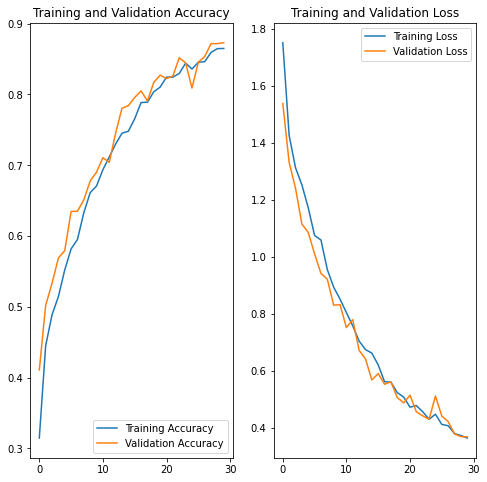

In [142]:
plot_accuracy(history_augm2,epochs)

In [145]:
# Lets store the accuracy in the DF
acc = history_augm2.history['accuracy']
val_acc = history_augm2.history['val_accuracy']
accuracy_history_df = accuracy_history_df.append([{"Type":"Class Imbalance","Training Accuracy":acc[-1],"Validation Accuracy":val_acc[-1],"Epochs":epochs}])
accuracy_history_df

,Type,Training Accuracy,Validation Accuracy,Epochs
0,Vanilla,0.886161,0.536913,20
0,Data Augmentation,0.627232,0.550336,20
0,Dropout,0.625558,0.583893,20
0,Class Imbalance,0.864991,0.873164,30


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### Observation
>- As we can see in the above table, after solving the issue of class imbalance and increasing the number of images with slight alteration using augmentor, the training accuracy has gone up to 87%. Hence we can say the we were able to solve the issue of underfitting.

>- We can also see that validation accuracy is also 87%, which is very close to training accuracy, hence there is no overfitting 

>- if we compare with the previous model's accuracy, using class rebalance really helped in improving the accuracy. 

>- The model was also evaluated with more data augmentation techniques but the accuracy reduced a lot because of varying differences between images. But it can be rectified by training it for more number of epochs.